In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass



* Now We have to make blur kernels and noise models
* We will use OpenCV blur function of different kernel sizes - 3,5
* We will use 2 noise models namely salt and pepper noise, gaussian noise
* We will randomly choose 1 blur kernel and 1 noise model
* First let's implement the noise models


Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:
    
    'gaussian'   Gaussian-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.

In [2]:
import cv2
from skimage.util import random_noise

def noisy(noise_typ,image):
    if noise_typ == "s&p":
        noise_img = random_noise(image, mode='s&p',amount=0.05)
        noise_img = np.array(255*noise_img, dtype = 'uint8')
        return noise_img
    elif noise_typ == "gaussian":
        # Generate Gaussian noise
        gauss = np.random.normal(0,0.5,image.size)
        gauss = gauss.reshape(image.shape[0],image.shape[1],image.shape[2]).astype('uint8')
        # Add the Gaussian noise to the image
        img_gauss = cv2.add(image,gauss)
        return img_gauss

Now let's degrade some images using 1 random noise models and 2 random kernel sizes

['s&p']
(321, 481, 3)


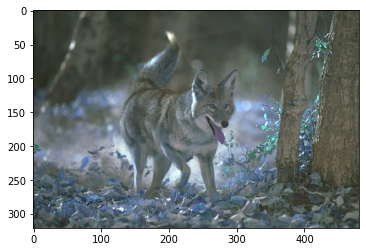

(321, 481, 3)


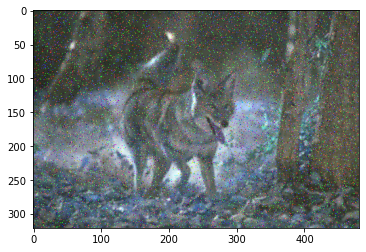

['s&p']
(321, 481, 3)


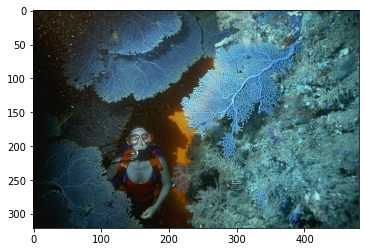

(321, 481, 3)


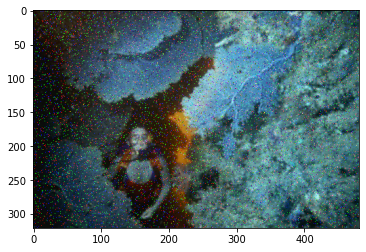

['s&p']
(321, 481, 3)


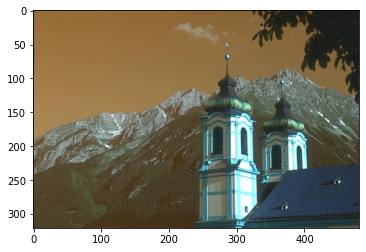

(321, 481, 3)


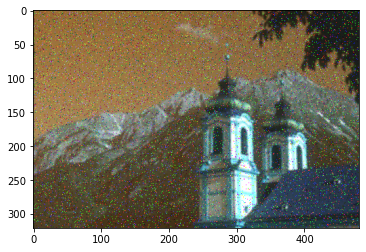

In [3]:
noise_models = ['s&p', 'gaussian' ]
kernel_sizes = [3, 5]

import random
random_select = 1
random_select_noise = 1

import matplotlib.pyplot as plt
from matplotlib import image


iter_image = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if iter_image<3:
            
            randomly_selected_noise_models = random.sample(noise_models, random_select_noise)
            randomly_selected_blur_kernels = random.sample(kernel_sizes, random_select)
            print(randomly_selected_noise_models)
            image = cv2.imread(os.path.join(dirname, filename))
            print(image.shape)
            plt.imshow(image)
            plt.show()
            for blur_kernel in randomly_selected_blur_kernels:
                image = cv2.blur(image, (blur_kernel,blur_kernel))
            
            for noise in randomly_selected_noise_models:
                image = noisy(noise, image)
            print(image.shape)
                
            plt.imshow(image)
            plt.show()
            
            iter_image = iter_image + 1
        

The Image degradation is sufficient. 

So there are total 300 images we will extract 40 image patches from each image and extract the central pixel of the patch
All the patches will be stored in the patches variable and all the central pixels will be stored in central_pixel variable

We will be using the helper code to extract the patches

In [4]:
W = 15 # Patch max window size
numPatches = 40 # Number of patches to be extracted from this image

patches = np.empty((numPatches*300,W,W,3), dtype=float) # Initilizing patch n-d array
central_pixel = np.empty((numPatches*300,1,1,3), dtype=float)
import math

image_iter = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        randomly_selected_noise_models = random.sample(noise_models, random_select_noise)
        randomly_selected_blur_kernels = random.sample(kernel_sizes, random_select)
        image = cv2.imread(os.path.join(dirname, filename))
        image2 = cv2.imread(os.path.join(dirname, filename))
      
        for blur_kernel in randomly_selected_blur_kernels:
            image = cv2.blur(image, (blur_kernel,blur_kernel))
            
        for noise in randomly_selected_noise_models:
            image = noisy(noise, image)
        
        for i in range(numPatches): # For number of patches
            x = random.randint(0, image.shape[0]-W-5) # Random x location so that the patch 
            y = random.randint(0, image.shape[1]-W-5) # Random y location
            patches[image_iter,:,:,:] = image[x:x+W,y:y+W,:]/255.0 # Extract patch
            central_pixel[image_iter,:,:,:] = image2[math.ceil(x+W/2),math.ceil(y+W/2),:]/255.0
            image_iter = image_iter + 1

print(central_pixel.shape)

(12000, 1, 1, 3)


Now we have to make the training and test data. We have a total of 12000 patches so we are dividing it into a set of 10000 and 2000. Here 10000 patches is train data and the remaining 2000 is test data.

In [5]:

w = 9 #subpatch size
X = np.empty((10000,w*w*3), dtype=float) # Initilizing patch n-d array
y = np.empty((10000,3), dtype=float)
X_test = np.empty((2000,w*w*3), dtype=float)
y_test = np.empty((2000,3), dtype=float)
for i in range(len(patches)):
    if i < 10000:
        X[i,:] = patches[i,np.int((W-w)/2):np.int(W-(W-w)/2),np.int((W-w)/2):np.int(W-(W-w)/2),:].reshape(1,w*w*3)
        y[i,:] = central_pixel[i,:,:,:].reshape(1,3)
    else:
        X_test[i-10000,:] = patches[i,np.int((W-w)/2):np.int(W-(W-w)/2),np.int((W-w)/2):np.int(W-(W-w)/2),:].reshape(1,w*w*3)
        y_test[i-10000,:] = central_pixel[i,:,:,:].reshape(1,3)

Now we will use random forest regressor with varying number of estimators to determine what number of estimator give the best accuracy. The tree depth is set to default that is 'None' which gives statistically the best accuracy

In [6]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [50,100,200,500,1000]
random_forest_scores = []
for estimator in n_estimators:
    model = RandomForestRegressor(n_estimators = estimator)
    model.fit(X, y)
    yhat_test = model.predict(X_test)
    mse = np.mean(np.square(y_test - yhat_test), axis=0)
    variance1 = max(yhat_test[:,0]) - min(yhat_test[:,0])
    variance2 = max(yhat_test[:,1]) - min(yhat_test[:,1])
    variance3 = max(yhat_test[:,2]) - min(yhat_test[:,2])
    temp_score = []
    temp_score.append(np.sqrt(mse[0]/variance1))
    temp_score.append(np.sqrt(mse[1]/variance2))
    temp_score.append(np.sqrt(mse[2]/variance3))
    random_forest_scores.append(temp_score)
    

Now we'll plot the scores in order to determine the best possible model from random forest regressor

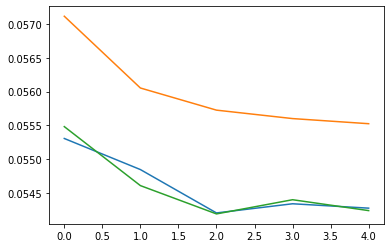

In [7]:
import matplotlib.pyplot as plt
plt.plot(random_forest_scores)

As we can see from the above plot the n_estimator 1000 gives the best rmse score which is 0.562

We'll now try neural network model. After fine tuning a lot of stuff here are the results of some iterations that i've tried

* Input
100
Output
0.042 - loss
0.047 - val_loss
Overfit

* Input
75
Output
0.045 - loss
0.048 - val_loss
Overfit

* Input
50
Output	
0.0418 - loss
0.0485 - val_loss
Overfit

* Input
10
Output	
0.0487 - loss
0.0458 - val_loss
good

* Input
10
Output	
0.0487 - loss
0.0460 - val_loss
good

* Input
10
5
Output	
0.0487 - loss
0.0460 - val_loss
good

* Input
20
10
Output	
0.0475 - loss
0.0468 - val_loss
good

* Input
10
5
5
Output	
0.0462 - loss
0.0475 - val_loss
good

* Input
20
10
5
Output	
0.0469 - loss
0.0473 - val_loss
good

* Input
50
25
5
Output	
0.0420 - loss
0.0498 - val_loss
good

* Input
50
25
5
Output
0.0469 - loss
0.0468 - val_loss
good

* Input
50
25
5
Output
0.0453 - loss
0.0476 - val_loss
good

* Input
50
25
5
Output
0.0427 - loss
0.0495 - val_loss
good

* Input
50
25
5
Output
0.0489 - loss
0.0455 - val_loss
good

* Input
50
25
5
Output
0.0491 - loss
0.0455 - val_loss
good

* Input
50
25
5
Output
0.0491 - loss
0.0455 - val_loss
good

The best model is input 50 25 5 output

lr=0.001
decay = 0.05
epoch = 100
batch_size = 64


In [8]:
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers


def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(50, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(w*w*3, 3)
model.optimizer.lr=0.001
model.optimizer.decay=0.05
history = model.fit(X, y, verbose=1, epochs=100, validation_data=(X_test, y_test), batch_size = 64)
yhat_test = model.predict(X_test)
mse = np.mean(np.square(y_test - yhat_test), axis=0)

variance1 = max(yhat_test[:,0]) - min(yhat_test[:,0])
variance2 = max(yhat_test[:,1]) - min(yhat_test[:,1])
variance3 = max(yhat_test[:,2]) - min(yhat_test[:,2])
temp_score = []
temp_score.append(np.sqrt(mse[0]/variance1))
temp_score.append(np.sqrt(mse[1]/variance2))
temp_score.append(np.sqrt(mse[2]/variance3))

print(temp_score)

2021-10-06 16:13:33.938062: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-06 16:13:33.938234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-06 16:13:38.942950: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 16:13:38.947149: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-06 16:13:38.947215: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-06 16:13:38.947244: I tensorflow/stream_executor/cuda/cud

Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.2680 - val_loss: 0.1858
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1727 - val_loss: 0.1798
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1654 - val_loss: 0.1759
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1636 - val_loss: 0.1736
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1738
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1596 - val_loss: 0.1734
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1590 - val_loss: 0.1716
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1588 - val_loss: 0.1712
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1570 - val_loss: 0.1699
Epoch 10/100
157/157 [==============================] - 0s 2ms/step - loss: 0.1573 - val_lo

According to the above comparison neural network model is performing better than Random forest regressor. So we'll use that model to predict the pixels.
Below is the function to regenerate image by predicting pixels

In [9]:
import tensorflow as tf
def restore_image(image):
    width, height = image.shape[0], image.shape[1]
    image = image/255.0
    image_new = np.reshape(image, (1,width,height,3))
    patches=tf.image.extract_patches(image_new,sizes=[1,w,w,1],strides=[1,1,1,1],rates=[1,1,1,1],padding='SAME') 
    patches=tf.reshape(patches,(-1,w,w,3)) 
    patches_tensor=np.asarray(tf.reshape(patches,(-1,w*w*3)))
    restored_image=model.predict(patches_tensor)
    restored_image=(restored_image*255).astype(int)
    restored_image=np.reshape(restored_image,(width,height,3))
    return restored_image

Let's see how our model is performing

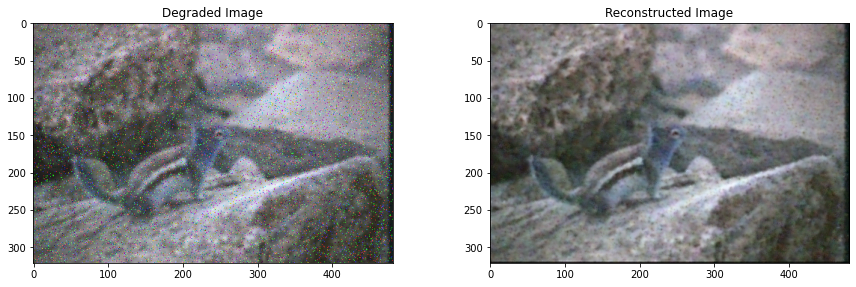

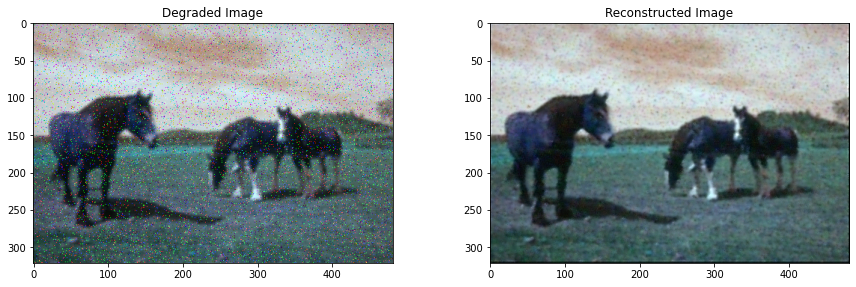

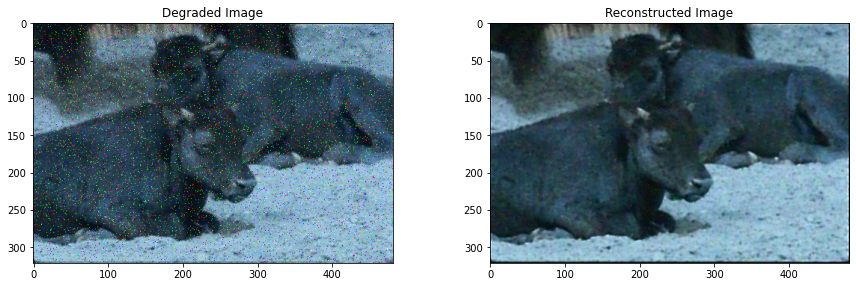

In [10]:
iter_image = 0
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 11<iter_image and iter_image<15:
            
            randomly_selected_noise_models = random.sample(noise_models, random_select_noise)
            randomly_selected_blur_kernels = random.sample(kernel_sizes, random_select)
            image = cv2.imread(os.path.join(dirname, filename))
            
            for blur_kernel in randomly_selected_blur_kernels:
                image = cv2.blur(image, (blur_kernel,blur_kernel))
            
            for noise in randomly_selected_noise_models:
                image = noisy(noise, image)
                
            
            image_restored = restore_image(image)
            plt.figure(figsize=(15,15))
            plt.subplot(3,2,1)
            plt.imshow(image)
            plt.title('Degraded Image')
            plt.subplot(3,2,2)
            plt.imshow(image_restored)
            plt.title('Reconstructed Image')
            
        iter_image = iter_image + 1

**Conclusions**

1. Degrading the images:
* As we increase the kernel size of blur filter the intensity of blurring increases
* Gaussian noise brings more degradation than s&p noise

2. Extraction of the patches
* As the patch window size increases more parameters are introduced in the model
* As the patch window size decreases, less parameters are introduced in the model
* The rmse score decreases as we decrease the window size

3. Random Forest Model
* We get the best results by random forest for the parameter depth=None
* We get the best results for the parameter n_estimator=1000 when iterated from 100 to 1000 at appropriate interval
* Training the random forest model took a lot of time as compared to the neural network model

4. Neural Network Model
* Increasing the hidden layers to more than 3 is overfitting the model
* Increasing the number of neurons above 100 is overfitting the model
* Learning rate decay is very important to decrease the learning rate after epochs
* Increasing the batch size lead to overfitting of the model

5. Image Reconstruction
* Model is working good while denoising the images
* Model couldn't deblur the images to very high extent
* If the image degradation is very high then model will not work good in cleaning the images
